The problem in a nutshell:

In [53]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import random
import tqdm

In [16]:
PROJECT_ROOT = os.path.normpath(os.path.join(sys.path[0], '..'))
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')

def list_absolute(directory):
    return sorted([
        os.path.join(directory, name)
        for name in os.listdir(directory)
    ])

def load_data(kind):
    data_dir = os.path.join(PROJECT_ROOT, 'data', 'processed', kind)
    Xs = np.concatenate([
        np.load(file) for file in list_absolute(os.path.join(data_dir, 'X'))
    ])
    Ys = np.concatenate([
        np.load(file) for file in list_absolute(os.path.join(data_dir, 'Y'))
    ])
    
    return (Xs, Ys)

In [10]:
(Xs_train, Ys_train) = load_data('train')
(Xs_test, Ys_test) = load_data('test')

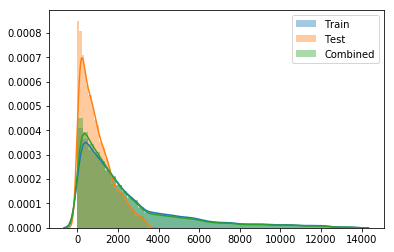

In [13]:
sns.distplot(Ys_train, label='Train')
sns.distplot(Ys_test, label='Test')
sns.distplot(np.concatenate([Ys_train, Ys_test]), label='Combined')
plt.legend()
plt.show()

If that plot doesn't convince you, there's also a proper statistical test.

What is the probability those two were drawn sets were drawn from the same distribution (they kinda were) and are that different by random sampling variability alone?

In [14]:
scipy.stats.ks_2samp(Ys_train, Ys_test)

Ks_2sampResult(statistic=0.3004359667812574, pvalue=0.0)

Note the $p$ value that gets rounded down to zero.

In [42]:
TEST_FRACTION = 0.2

basenames = os.listdir(os.path.join(DATA_DIR, 'interim', 'X'))
num_test = int(len(basenames) * TEST_FRACTION)
num_train = len(basenames) - num_test
labels = ['test'] * num_test + ['train'] * num_train

test_means, train_means = [], []

for i in range(100):
    random.shuffle(basenames)

    Ys_clustered = {
        'train': [],
        'test': []
    }

    for (kind, file) in zip(labels, basenames):
        Ys_original = np.load(os.path.join(DATA_DIR, 'interim', 'Y', file))
        Ys_clustered[kind].append(list(Ys_original))

    train_dist = np.array(sum(Ys_clustered['train'], []))
    test_dist = np.array(sum(Ys_clustered['test'], []))

    train_means.append(train_dist.mean())
    test_means.append(test_dist.mean())

/usr/lib64/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


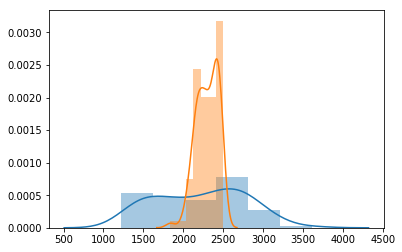

In [43]:
sns.distplot(test_means, label='Test means')
sns.distplot(train_means, label='Train means')
plt.show()

In [45]:
np.abs(np.array(test_means) - np.array(train_means)).mean()

596.2945690336554

In [46]:
Ys_train.mean() - Ys_test.mean()

1516.8858456734379

In [47]:
sum(np.abs(np.array(test_means) - np.array(train_means)) < (Ys_train.mean() - Ys_test.mean()))

99

In [50]:
def js_distance(P, Q):
    overall_min = min(P.min(), Q.min())
    overall_max = max(P.max(), Q.max())
    kP = scipy.stats.gaussian_kde(P)
    kQ = scipy.stats.gaussian_kde(Q)
    xs = np.linspace(overall_min, overall_max, 100)
    Psmooth = kP(xs)
    Qsmooth = kQ(xs)
    Msmooth = (Psmooth + Qsmooth) / 2
    return 0.5 * (scipy.stats.entropy(Psmooth, Msmooth) + scipy.stats.entropy(Qsmooth, Msmooth))

In [51]:
js_distance(Ys_test, Ys_train)

0.10986693208679567

In [61]:
TEST_FRACTION = 0.2

basenames = os.listdir(os.path.join(DATA_DIR, 'interim', 'X'))
num_test = int(len(basenames) * TEST_FRACTION)
num_train = len(basenames) - num_test
labels = ['test'] * num_test + ['train'] * num_train

distances = []

for i in tqdm.trange(100):
    random.shuffle(basenames)

    Ys_clustered = {
        'train': [],
        'test': []
    }

    for (kind, file) in zip(labels, basenames):
        Ys_original = np.load(os.path.join(DATA_DIR, 'interim', 'Y', file))
        Ys_clustered[kind].append(list(Ys_original))

    train_dist = np.array(sum(Ys_clustered['train'], []))
    test_dist = np.array(sum(Ys_clustered['test'], []))
    
    distances.append((js_distance(train_dist, test_dist), basenames))

100%|██████████| 100/100 [02:06<00:00,  1.09s/it]


/usr/lib64/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


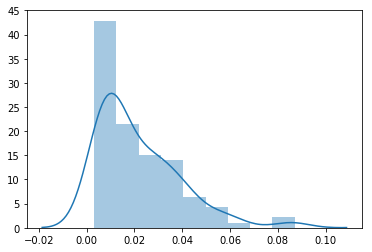

In [60]:
sns.distplot([a for (a, b) in distances])
plt.show()

In [63]:
min(distances)[1]

['chb07_12_0.npy',
 'chb15_28_0.npy',
 'chb03_34_0.npy',
 'chb19_29_0.npy',
 'chb07_13_0.npy',
 'chb06_09_0.npy',
 'chb12_10_1.npy',
 'chb04_28_0.npy',
 'chb20_13_0.npy',
 'chb21_20_0.npy',
 'chb10_31_0.npy',
 'chb05_06_0.npy',
 'chb12_38_3.npy',
 'chb15_06_0.npy',
 'chb10_20_0.npy',
 'chb12_38_2.npy',
 'chb15_49_0.npy',
 'chb21_19_0.npy',
 'chb24_03_0.npy',
 'chb13_58_0.npy',
 'chb13_55_0.npy',
 'chb20_15_1.npy',
 'chb10_27_0.npy',
 'chb04_08_0.npy',
 'chb18_35_0.npy',
 'chb13_62_2.npy',
 'chb10_38_0.npy',
 'chb09_06_0.npy',
 'chb12_42_1.npy',
 'chb13_40_0.npy',
 'chb15_22_0.npy',
 'chb20_14_0.npy',
 'chb03_02_0.npy',
 'chb12_42_0.npy',
 'chb12_23_1.npy',
 'chb13_21_0.npy',
 'chb01_03_0.npy',
 'chb15_40_1.npy',
 'chb09_08_0.npy',
 'chb22_38_0.npy',
 'chb14_17_0.npy',
 'chb12_33_0.npy',
 'chb01_15_0.npy',
 'chb12_10_0.npy',
 'chb05_17_0.npy',
 'chb22_20_0.npy',
 'chb04_05_0.npy',
 'chb08_21_0.npy',
 'chb13_40_1.npy',
 'chb15_54_2.npy',
 'chb15_54_1.npy',
 'chb01_21_0.npy',
 'chb23_09_2